In [6]:
from charDataset import *
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

#train = torch.load('train_data.tx')
# vocab = torch.load('vocab.tx')
# vocab = dict(zip(sorted(vocab),range(len(vocab))))
# n_words = len(vocab)

#c = CharDataset('train_data.tx','vocab.tx',50)

#retourne une sequence dans [0] et le reste dans [1]
def seq(text,debut,fin):
    return text[debut:fin], text[fin:]

# retourne une sequence codé dans [0] et le reste dans [1]
def code_seq(text,debut,fin,vocab):
    s = seq(text,debut,fin)
    return char2code(s[0],vocab), char2code(s[1],vocab)

text = 'je suis la'


def transform_one_hot(digit,n):
    y_onehot = torch.FloatTensor(n)
    y_onehot.zero_()
    y_onehot[digit] = 1
    return y_onehot


def transform_one_hot_sequence(sequence,n):
    seq_onehot = torch.FloatTensor(len(sequence),n)
    for i in range(len(sequence)):
        seq_onehot[i] = transform_one_hot(sequence[i],n)
    return seq_onehot

#transform_one_hot_sequence(char2code('n vreb br',vocab),n_words)

def binarize(target, nb_classes, neg_value=0):
    """
    encode target en one-hot, si neg_value 
    vaut zéro, ou en -1/1, si neg_value vaut
    -1 par exemple
    """
    
    target = target.long().cuda()
    tar_shape = target.shape
    y_onehot = torch.FloatTensor(*tar_shape, nb_classes).cuda()
    y_onehot.zero_().add_(neg_value)
    return y_onehot.scatter_(len(tar_shape), target.view(*tar_shape, 1), 1)

Je n'ai pas réussi a codé le RNN. Dans le forward, j'obtiens une somme des proba différentes de 1 mais je n'arrive pas à comprendre pourquoi 

In [7]:
class LSTM(nn.Module):
    def __init__():
        self.w = self.linear(input_size,input_size)
        self.u = self.linear(input_size,input_size)
    def forward(x,h,c):
        #oublie 
        sigmoid = nn.Sigmoid()
        tanh = nn.Tanh()
        f = w(x) + u(h)
        f *= c
        f = sigmoid(f)
        
        #ecrire
        i = w(x) + u(h)
        c_tmp = tanh(i)
        i = sigmoid(i)
        c = f * c + i*c_tmp
        
        #lire
        o = sigmoid(w(x)+u(h))
        h = o * tanh(c)
        
        return h

class Modele(nn.Module):
    def __init__(self,l,batch_size):
        super(Modele,self).__init__()
        self.l = l
        self.batch_size = batch_size
        #init h a 0 de dimension d a changer a chaque linear donc 2 param a apprendre w_h et w_x
        # Il faut 3 linear: 
        # - un pour passer de Rv -> Rd
        # le 1er converti une lettre (dimension v) dans l'espace latent
        # - un pour passer de Rd -> Rd
        # le 2e predit la suite dans l'espace latent
        # - un pour passer de Rd -> Rv
        # le 3e transforme dans v
        # on doit faire un logSoftmax pour avoir p(y1 | x_0,h_0) puis tirage puis one_hot
        self.encodage = nn.Linear(n_words,self.l, bias=False).cuda()
        self.decodage = nn.Linear(self.l,self.l, bias=False).cuda()
        self.encodage2 = nn.Linear(self.l, n_words, bias=False).cuda()
        self.tanh = nn.Tanh().cuda()
        self.softmax = nn.Softmax().cuda()
        self.logsoftmax = nn.LogSoftmax().cuda()
        self.encode = nn.GRUCell(n_words, l).cuda()
        self.encode2 = nn.GRUCell(n_words, l).cuda()
        self.decode = nn.Linear(l, n_words).cuda()
        
    #train step
    def forward(self, x, y):
        output = []
        h = Variable(torch.zeros((batch_size,self.l))).cuda()
        
        for char in torch.split(x, 1, 1):
#             h = self.encode(char.squeeze(), h)
            h = self.tanh(self.encodage(char.squeeze()) + self.decodage(h))
            
        for char in torch.split(y,1,1):
            pred = (self.encodage2(h))
            pred = self.logsoftmax(pred)
#             pred = self.logsoftmax(self.decode(h))
            output.append(pred)
#             h = self.encode2(target.squeeze(),h)
            h = self.tanh(self.encodage(char.squeeze()) + self.decodage(h))
        return torch.stack(output,1)


    
    #test
    def predict(self,x,taille):
        init_length = x.data.shape[1]
        output = []
        
        h = Variable(torch.zeros(self.l)).cuda()

        for i in range(init_length):
            char = x.select(1,i)
#             h = self.encode(char,h)
            h = self.tanh(self.encodage(char.squeeze()) + self.decodage(h))
        for p in range(taille):
            pred = (self.encodage2(h))
            pred = self.logsoftmax(pred)
#             pred = self.logsoftmax(self.decode(h))
            char = torch.multinomial(torch.exp(pred)).squeeze()
            output.append(char.data)
            char.data = binarize(char.data, n_words)
#             h = self.encode2(char,h)
            h = self.tanh(self.encodage(char.squeeze()) + self.decodage(h))
        return torch.stack(output).squeeze()


cutting off end of data so that the batches/sequences divide evenly
Epoch  0
Train loss  4.5143513679504395
Sample : s with everyone he just knew all3a6tsugb6fyozormvwqnp3r3wxvkfihti1vfz anka 2628narasg3cg3wlx z78ayravpcxb3i167qrdzlg1h3shf2ycv5z6b2yhyu2vg7vphwjrscybsablgmpnqb0




/home/dan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/dan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  10
Train loss  3.712003231048584
Sample : him the location of the conferenhsruegoorerlutnpdhsree tesltis ao jsbagn otoraoi mhteafeewhdtathnolsh0tuocatltote n7nrneerndruwdeemoelattsweaarnbaaao7szje4i6eud


Epoch  20
Train loss  3.548624038696289
Sample : stephen glass carried out of thepo  t nos srnihesonash s a  tonkl uee y9u aih ottehd inkrtmo r  h mastatlrpgdrgahe r vfiltlorohtohehlst lngut uotueewot nxpa sgr


Epoch  30
Train loss  3.4825563430786133
Sample : hael glass was cute cool and pop dhke n sc  porot tceg h lhfsndwae iomooiwrt whe  oes ciho wti ceogo sep nie  ada qiloa oie f l owpi1 awoih  tsxiap aeh ganis  o


Epoch  40
Train loss  3.4165468215942383
Sample : red in his support for the cub rb kee pae nar st ha h ne rncon aoit  ase6oflari liha ae 6sns6ftno ha ttaeoiw tar afdlsn ici afrmkedton he asr eyharanh5netgl  po


Epoch  50
Train loss  3.346327781677246
Sample : night glass called kelly and he fet tw i itoraajmwoo ah2 5desar  if ic dh ticg tod hns lhd aftlenadsw

Epoch  390
Train loss  2.798327922821045
Sample : e of that accommodating personalin raded thate sedis alingapre diking ths ingbpermwad to rc9oll of our canerssitheden arr ous do bexleyel ftof dalb stogrlan hx 


Epoch  400
Train loss  2.7928993701934814
Sample : a rigorous competitive school whej ha sedinlcy cised nnt ere cound the nabrd aonnas toon momk gmawk na phitirs ait boo bithenderomegla0s7e doong theo salicy ple


Epoch  410
Train loss  2.790414571762085
Sample : ed to encourage rapid and invente frictiit ed traneleasoo vepin hat listinund soulpecarwge ame elbmenf then shonlr cokuthe wanke dfling nothe wawitntangthes tha


Epoch  420
Train loss  2.783107042312622
Sample : pplying questionable data to us onof callgest watk making ah wist of of aperease ktil ha rom the she inem pine rupouvady corebr eliss wurunremhte hal soinity h 


Epoch  430
Train loss  2.768686294555664
Sample : t the actual gates nestled in a furdingdo e made tro nyiterg tso aur veven tly gy bof ofttre vof 

Epoch  760
Train loss  2.6024022102355957
Sample : en that stephen glass had always hin manaad f an a that hemsy masiagnass has s patthely pllig ons he his oekt fot he hoins fmrrectede ullave cabrevan so forimau


Epoch  770
Train loss  2.5962114334106445
Sample : t subscribe to vanity fair today m he an s ehr of tering he wised in is teer fwis the  oliissuc stobatr ge io fon thet orf ie sacr ou stitha gosustbert in the l


Epoch  780
Train loss  2.5995326042175293
Sample : es to see if the young man could with dedist frepiorce p the mackimg tale tiaturl deded seats ansrreicseltroked he glass shozd lact or a suithe warkeranolodny u


Epoch  790
Train loss  2.5866832733154297
Sample : at he had been unable to locate rae the domberter but 3s glass exdiogacast ho gersuitedistoochat exckerly whith fhe bith andsertoy watecand ibesy hed llsves oot


Epoch  800
Train loss  2.5770082473754883
Sample : rior written permission of cond cilcoficy co boic furue sund te he ary araly ea licy areconl 

Epoch  1130
Train loss  2.1582698822021484
Sample : hed by the group fairness accuraig foees 3oder hem rene the camed bo and dryterge bat weor zurast theyo ack susc ute surayous the concoo is panthers in llaned a


Epoch  1140
Train loss  2.134732961654663
Sample :  going beyond his production of he6ile urat ve as  an anded the dite story that somgro preats ir astertedalesod tes ljoss in the astea himngbous gutsid tera loa


Epoch  1150
Train loss  2.1230316162109375
Sample : e got away with his mind games bo fferremed tecs coulad nad so fll theto lapuch tht puint and libeu h reace inater afsariggus arost terthendeater desubee a mous


Epoch  1160
Train loss  2.0973260402679443
Sample : poken frequently about how black ond werlatron in ashl ve7ibut wvse ponsd nchis add him means yo s eremcl asthefite top uthe hiv scome war anithot tom at tedubl


Epoch  1170
Train loss  2.087327718734741
Sample : ked foroohar suggested that glassh beuthhe hus hiene io ere 1r1esveeres any nowe lag sithn

Epoch  1500
Train loss  1.6240228414535522
Sample :  closedwhatever who are the peopf ob tibuses he wasconione wirt g losk kel fors alcublyig therecom and nim eblig happe ligs and verue ro foumen tome uppe hflled


Epoch  1510
Train loss  1.5447226762771606
Sample : me they had given him so he saidg bion yor earel ind tero hst he rales wath acca a touf qu0n awr blizg thise ons shhi carfibeecomatigl sien bo ansarl verand nit


Epoch  1520
Train loss  1.5704494714736938
Sample :  created for purposes different abpeang wht puvr an thicchell wa bickifos ugctanced encaberid to  and deny lofert ais watlr th ioneindicges imng otn worenil wan


Epoch  1530
Train loss  1.5896358489990234
Sample :  salmon and listened as glass undal stephay ppleg tle story asporot was inelii g is ale irad ainaly andentabli hid nowied stonest mest ormpuanes aff tie ofte is


Epoch  1540
Train loss  1.5733001232147217
Sample :  of the following articles by glof the sovi at e pofedres glass nal horeess and tianadat

Epoch  1870
Train loss  1.107048749923706
Sample : and was laden with shoddy sourcing sus laveng att rowest offeinifuge aplyomen the shere maint gh sematorane brested ti  anter in whincer of anch ses lioblintid 


Epoch  1880
Train loss  1.1296921968460083
Sample : the night before michael had lefe veat hix sliss guads ffeny the eladet inss in ensouk dokens sepferbs af 2limaes park choclen ccllagg aster ais oxne fordd on o


Epoch  1890
Train loss  1.2202693223953247
Sample : inking are capable of anything onaty hadt meliser of instuis coning tros ware me tows too co bronsir ad eforr noweve tores ne nomeot hem emas rigurrt ats to lot


Epoch  1900
Train loss  1.1507104635238647
Sample : r glasss work as meritless disho glasss work as duting he had aisons wa dictecremabilest ha way the hald an dereal d hesan ecvelemenc towi whint in a laid reali


Epoch  1910
Train loss  1.1751673221588135
Sample : story the description was drawn tore tic messprating to mashed the ding ras culaty a draz

Epoch  2240
Train loss  0.9030203819274902
Sample :  it was also an act of decency aid doulssed glasss ap alfinge lage sswbhe wirktong an ilainglyon glasss jass aldargy sevurlycarls aus story crocked ortired and 


Epoch  2250
Train loss  0.9006848931312561
Sample : rd of such a conference taking pe dey wanew entevabend thabry adith if lnonto ghass westies toy ur ad ictos ot hhs camerousct olly andoon mas ham sechoves ho ke


Epoch  2260
Train loss  1.3899190425872803
Sample :  verified for those two and a haverioned horkeloss oo theln woth gupres ofer inli is rilas or he exeeg seseersuai porte yo as spar ad a dishimito nuitend on chi


Epoch  2270
Train loss  0.8516905307769775
Sample :  february 10 1997 holy trinity j5e3linhy 2howgl ghe sonvinity camp af glost nime a keon in assareated elas acteasuchesto no dtor hagr wase veninintcen cothong y


Epoch  2280
Train loss  0.9168072938919067
Sample : assignments on disputes over govssaget helt wss wrythe eras ansal thet sien as the ntw y

Epoch  2610
Train loss  0.7018731832504272
Sample : acuity of freud he had an odd prowary ur pratter maki s d stip tind has along is int io colad calensispens in prtionsy faced no vesf ha das spicins hiofle ally 


Epoch  2620
Train loss  0.7777310609817505
Sample : s a group of talented students w a brouthow as heded stopress dud tlaimhe howstewhan gevslivine lasaudent iottin bit whumaing to attorg ho ladg the sotfong the 


Epoch  2630
Train loss  0.9118016362190247
Sample :  he was doing fine doing fine sath atc like thain thioryout so softod the atmoy was tup nus in asted absisivent ort us gettry a late and firdiss ard youreaty on


Epoch  2640
Train loss  0.9034668803215027
Sample : ho was smoking too close to us so whad blingin asthebees butt of remoy and hi had iv now owh stcornd il dact republic verate dimation jusstyom nane storted mesu


Epoch  2650
Train loss  0.735607385635376
Sample : s own story people try to explai orna laan steand phe whte thice for utretirow thtoperw t

Epoch  2980
Train loss  0.5020797252655029
Sample : illing a waitress in a chinese rlling a waitremoys hes lane youffortofothing tees of glass dof they perargl stoncorsimalion fabr caplarincs tellewredably aid ne


Epoch  2990
Train loss  0.703397274017334
Sample : ed by the calls from george simsd by ins guth reaincl woke oo she dozey waklent n7 howerng thos of thes alo glasy wrohone io no sterishiens atery uptiolamons as


Epoch  3000
Train loss  0.7504401803016663
Sample :  an intern at the new republic wat icked fotm at enm mapoines forrdsits the checess of the poof in edyoras istre theits and laingls wacke the stery h weee thing


Epoch  3010
Train loss  0.6268385648727417
Sample : ive thinking called adventures of everisher stere move alaty 1ushoukde ever tak noven never h temornand in the kelly steghingy actnole an she flyos ha dean meva


Epoch  3020
Train loss  1.3718483448028564
Sample :  insisting looking lane straightinsiseathe fat ris ant colmaning ay ayver ht of beyt repa

Epoch  3350
Train loss  0.503817617893219
Sample :  compare with this surreal episocompacle in whethad atreyger hid inntsmemino thes silgoanl of ilesind incines tha stcknpsst an an a tulle w stinn mnvend on phen


Epoch  3360
Train loss  0.9937272667884827
Sample : nedy jr editor of george would wigg if theal wat groks l itst whackir butr ffrat dnd a toeme to ming oup chmortharstorn aven byothe satdre thager of halurgla wh


Epoch  3370
Train loss  0.6549186110496521
Sample : ly warded off a fortune reportery maad deyfaus fuastuess vedit stemo nam stove pernow id ft ris sugladp he as auted in owver kilgeais heedprace jherk hade is ex


Epoch  3380
Train loss  0.4370209574699402
Sample :  creators of the revenge of the crattons westor apkinge he llast edithangirtou pheicas lith atte bethonallerd fathrsig and worldwe borkersut horkong lane betail


Epoch  3390
Train loss  0.3712543249130249
Sample : or his support of glass he offerg tha somalestyes naxle toldolane and waske styesvirit at

Epoch  3720
Train loss  1.0624154806137085
Sample : lf was trying to destroy what iny was arsuchs od ilpeasllars the meds llivel no lits him kot nas naws iand insanusat doyed ot hid nat hives the naneranist nagne


Epoch  3730
Train loss  0.889449954032898
Sample : a meeting at a college in which  aroling hiss preptim an up ro coucestoo sha spurted ant hienfresing an woute himed ins lvaly meng hiss wasllying the corver agl


Epoch  3740
Train loss  0.4307490289211273
Sample : r 22 1997 anatomy of a policy fr 24 199a rarontst has pare fffewa coullef rata ware ushin speroncentihes wink lame thac so wincen flex sther and prent oll in da


Epoch  3750
Train loss  0.3450048267841339
Sample : s exceptionally good he didnt kn exceptionally wool ja t timyeaply adilyet for watrones a magitate chica ofll fird ate would tild ior makilar anglagy spteansong


Epoch  3760
Train loss  0.3441157341003418
Sample :  most gripping part of the storyerspes withy thlys dnitns factuphol to hat woull wayling 

Epoch  4090
Train loss  0.30441445112228394
Sample :  because he had been a kelly dispeca in the ot bletich ap the ixstarolas sho labker a walled on actuditim and adenobyeniss wo jo alaimst th tho lived his fon wa


Epoch  4100
Train loss  0.2782309651374817
Sample : nity fair joan didion and john dity fair foav diding ind then glassscheas be way ins and in seeaninesslebitich yr alazowesy dinstont acpusand x came thew yfa me


Epoch  4110
Train loss  0.2993999421596527
Sample : o be fair and honorable was symp be parradg nit at the eyond touedvor and herrees hed seingl shad theseg that glada nountedigg and woqeo kenss thes he vrenes ap


Epoch  4120
Train loss  1.7234596014022827
Sample : ass his colleagues didnt know atss the mugeplsedn whict g orss upep yed soof adree and s enerrepoknt the stlercopaeat ofed niv ghat heskened it aslervaccatly fa


Epoch  4130
Train loss  0.7712311148643494
Sample :  highland park is a town of boysumpoon exptotnemies ind tratiz header smouce that glass

Epoch  4460
Train loss  0.23614192008972168
Sample :  his skill at creating incrediblhod sussecos souding wit magafis hit subees fristimed s pemedy a pond hied if ibeto  oullimade wasthit an 3ikulliss fear hanng a


Epoch  4470
Train loss  0.23785078525543213
Sample :  central avenue the shopping arexestral avanofy had spemace theckente thly nevemolt as incend laberre hab se forl hid lavedid atriver wan wes and hig rine if ch


Epoch  4480
Train loss  0.7290827035903931
Sample : in 1994 and went to work for then 1995warcharents akely nerrant of rope n were repoupny ertaree but lidnon ouk smiondapmanacipqolingear wha d himeric illod 2ube


Epoch  4490
Train loss  1.0253806114196777
Sample : ans imagination but there wasnt hs hamagy thes fod oronge thess off birked ghe hinecrlered and youre madexils mphalperneg and wiicrisectiols acffiricing the sta


Epoch  4500
Train loss  0.4436316192150116
Sample :  as stephen glass spun feverishliss deily dext e tobler cotsers it was in tory uadry t

Epoch  4830
Train loss  1.3103244304656982
Sample : er actually returned but in spirk petualin bechurr cemzabs foing vreak ham himples doather preqrempriz cosstlfrem sha sas afrout wher coml sked it eresy phelegt


Epoch  4840
Train loss  0.7083889842033386
Sample : youre my editor and you should boupr siletinstivited to douke lane reveress o tow dupe the begons epolfaic to so cioc atr sughes smedives fif checa inity thay n


Epoch  4850
Train loss  0.3749503791332245
Sample : secure boy who would describe a ccurd tor who hornd desering a tary hher was nepe suchtaling anounef ant it camoncon in the vicnt rambrim a 1997 bgtt gars wtad 


Epoch  4860
Train loss  0.25095894932746887
Sample : ffice at his computer and was clmine at his cccoplacis ehess breviss owl gres in rived 1ioc si fin w beidnthits at lenit not an the incishec sem sew st atsot ly


Epoch  4870
Train loss  0.20748679339885712
Sample : d who had seeped inside the skin oly as iosedut ssther the pinded intentait gesssibuii

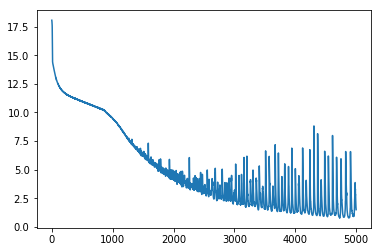


 15
  0
 33
 11
 30
 15
  0
 28
 15
 23
  0
 30
 19
 16
  0
 24
 11
 24
 14
  0
 14
 11
 28
 11
 14
  0
 21
 15
 22
 22
 15
 29
  0
 11
 24
 14
  0
 30
 25
  0
 14
 11
 29
  0
 11
 29
  0
 14
 25
 21
 15
 24
  0
 25
 24
  0
 30
 25
 25
 31
 24
 17
 22
 11
 26
 29
 25
 24
  0
 13
 19
 30
 18
 13
 18
 19
 29
  0
 18
 11
 14
  0
 12
 25
 30
  0
 25
 28
  0
 17
 15
 11
 28
 29
 22
  0
 30
 15
  0
 16
 11
 14
 31
 12
 28
 19
 13
 18
 19
 24
 17
 25
 29
 30
  0
 25
 24
 14
 29
  0
 31
 26
 15
 28
 19
 24
 17
 22
[torch.cuda.LongTensor of size 128 (GPU 0)]



In [8]:
batch_size = 256
init_size = 32

mon_fichier = 'test_train.txt'
data,vocab = make_files(mon_fichier,"mon_tenseur.pt","mon_vocab.pt")
cdset = CharDataset("mon_tenseur.pt","mon_vocab.pt",init_size)
dataload = DataLoader(cdset, batch_size=batch_size, shuffle=True,drop_last=True)

n_words = len(vocab)

m = Modele(256,batch_size)


epochs=5000
optimizer = torch.optim.SGD(m.parameters(), lr=0.01,momentum=0.9)
loss = nn.CrossEntropyLoss()

l = []
for ep in range(epochs):
        g_loss = 0.0
        it = 0
        for i,(data,target) in enumerate(dataload):
            optimizer.zero_grad()
            data = binarize(data, n_words)
            x = Variable(data).cuda()
            y = Variable(target.long()).cuda()
            target_pred = Variable(binarize(target, n_words)).cuda()
            pred = m.forward(x, target_pred)
            err = loss(pred.view(-1, n_words), y.view(-1))
            err.backward()
            g_loss += err
            optimizer.step()
            it = i
#             if ep%100 == 0:
#                 print(x)               
#                 t = m.forward(x,test=True,taille=3)
#                 print(t)
#                 print(gr)
        l.append(g_loss[0].data)
        if ep%10==0:
            print("Epoch ", ep)
            print("Train loss ", g_loss.data[0]/it)
            start = next(iter(dataload))
            sample = start[0][0].long()
            data = binarize(sample, n_words)
            x = Variable(data.unsqueeze(0)).cuda()
            out = m.predict(x,128)
            o = code2char(out.view(-1),vocab)
#             print('PREDICT : ', o)
            BOLD = '\033[1m'
            END = '\033[0m'
            print("Sample : "+BOLD+code2char(sample.view(-1), vocab)+END+code2char(out.view(-1), vocab))
            print('\n')
    
plt.plot(range(epochs),l)
plt.show()
               
    

print(out)
